In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
from pathlib import Path

from noise import *

In [2]:
counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin']
niche_data_dir = Path('/home/isaac/niche_data/')

vardict = {}
timedict = {}
for counter in counters:
    countervars = []
    times = []
    for datepath in niche_data_dir.iterdir():
        counter_data_dir = datepath / counter
        if counter_data_dir.exists() and list(counter_data_dir.iterdir()):
            noisefiles = np.array([p for p in counter_data_dir.iterdir() if p.name.endswith('bg.bin')],dtype='O')
            if len(noisefiles) > 0:
                timestamps = np.array([f.name[8:14] for f in noisefiles]).astype('int')
                sorted_noisefiles = noisefiles[np.argsort(timestamps)]
                closed_noisefiles = sorted_noisefiles[::2]
                open_noisefiles = sorted_noisefiles[1::2]
                try:
                    closedvar = np.mean([np.var(read_noise_file(f)) for f in closed_noisefiles])
                    openvar = np.mean([np.var(read_noise_file(f)) for f in open_noisefiles])
                    if openvar>closedvar:
                        countervars.append(openvar - closedvar)
                    else:
                        countervars.append(closedvar - openvar)
                    date = datepath.name
                    y = date[:4]
                    m = date[4:6]
                    d = date[6:]
                    times.append(np.datetime64(y+'-'+m+'-'+d))
                except:
                    continue
    vardict[counter] = np.array(countervars)
    timedict[counter] = np.array(times)
            
    
            
            
            
        

Text(0, 0.5, 'open variance - closed variance')

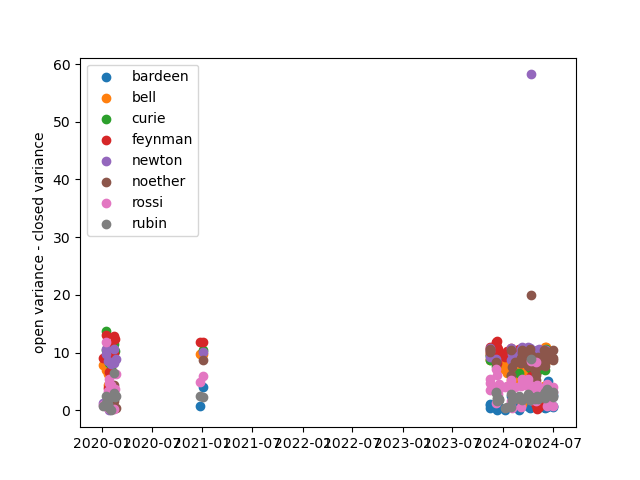

In [3]:
plt.figure()
for counter in counters:
    mask = np.abs(vardict[counter])<1.e2
    plt.scatter(timedict[counter][mask], vardict[counter][mask], label = counter)
plt.legend()
plt.ylabel('open variance - closed variance')